<font size="6">Course: Use Normet for Weather Normalization</font>

<font size="4">Objectives: The purpose of this course is to demonstrate how to perform weather normalization using Normet and to showcase the classic steps involved in the process, followed by a visual analysis of the data after weather normalization.</font>

<font size="4">1: Data preparation and visualization (we have prepared the london traffic air quality station data and meteorological data)</font>

<font size="4">2: AutoML-based weather normalisation</font>

<font size="4">3: Normalized data visualization</font>

<font size="4">4: Exercise</font>

In [1]:
import pandas as pd
# normet package contains the weather normalization function which is friendly for users
import normet as nm
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
import seaborn as sns

<font size="6">Step1: Data Preparation and Visualization</font>

<font size="4">1.1 Load the pollutation data</font>

we prepare a UK urban traffic air quality monitor station-London Marylebone Road (London). We will use the station data to introduce the weather normalization process

In [139]:
# load the pollution data
df=pd.read_csv('../dataset/MY1.csv',parse_dates=['date'],index_col='date')
# the columns of this dataframe - df
print(df.columns)
# preview the first 5 lines of the loaded data 
df.head()


Index(['O3', 'NO', 'NO2', 'SO2', 'CO', 'PM10', 'location_type', 'PM2.5',
       'temp', 'v10', 'ssrd', 'blh', 'sp', 'rh2m', 'u10', 'tp'],
      dtype='object')


/var/folders/8p/ny4s42v97yz7qg_ysw7z_rm00000gp/T/ipykernel_12731/3067243948.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df=pd.read_csv('../dataset/MY1.csv',parse_dates=['date'],index_col='date')


,O3,NO,NO2,SO2,CO,PM10,location_type,PM2.5,temp,v10,ssrd,blh,sp,rh2m,u10,tp
date,,,,,,,,,,,,,,,,
2010-10-13 12:00:00,22.0,61.0,88.0,5.0,0.3,22.0,Urban Traffic,16.0,9.0,-2.915381,1032762.56,823.39966,101350.99,74.64452,-1.647905,0.0
2010-10-13 13:00:00,28.0,45.0,69.0,5.0,0.2,22.0,Urban Traffic,10.0,9.0,-3.091130,883327.20,834.39100,101301.67,72.99228,-1.395934,0.0
2010-10-13 14:00:00,24.0,50.0,76.0,5.0,0.3,26.0,Urban Traffic,10.0,8.8,-3.433254,1038951.25,857.62600,101267.99,72.24144,-1.281452,0.0
2010-10-13 15:00:00,26.0,43.0,71.0,5.0,0.3,24.0,Urban Traffic,10.0,8.6,-3.658799,710545.70,850.04333,101246.85,71.95577,-1.228140,0.0
2010-10-13 16:00:00,26.0,43.0,76.0,5.0,0.5,22.0,Urban Traffic,12.0,8.4,-3.668172,333183.62,846.91284,101236.37,71.84961,-1.210743,0.0


The meteorological parameters are: 10m u-component of wind (u10, m/s), 10m v-component of wind (v10, m/s), temperature (temp, ℃), boundary layer height (blh, m), surface pressure (sp, hPa), surface solar radiation downwards (ssrd, J/m2), total rainfall (tp, m), relative humidity (rh2m, %).

<font size="4">1.2 Data visualizaiton</font>

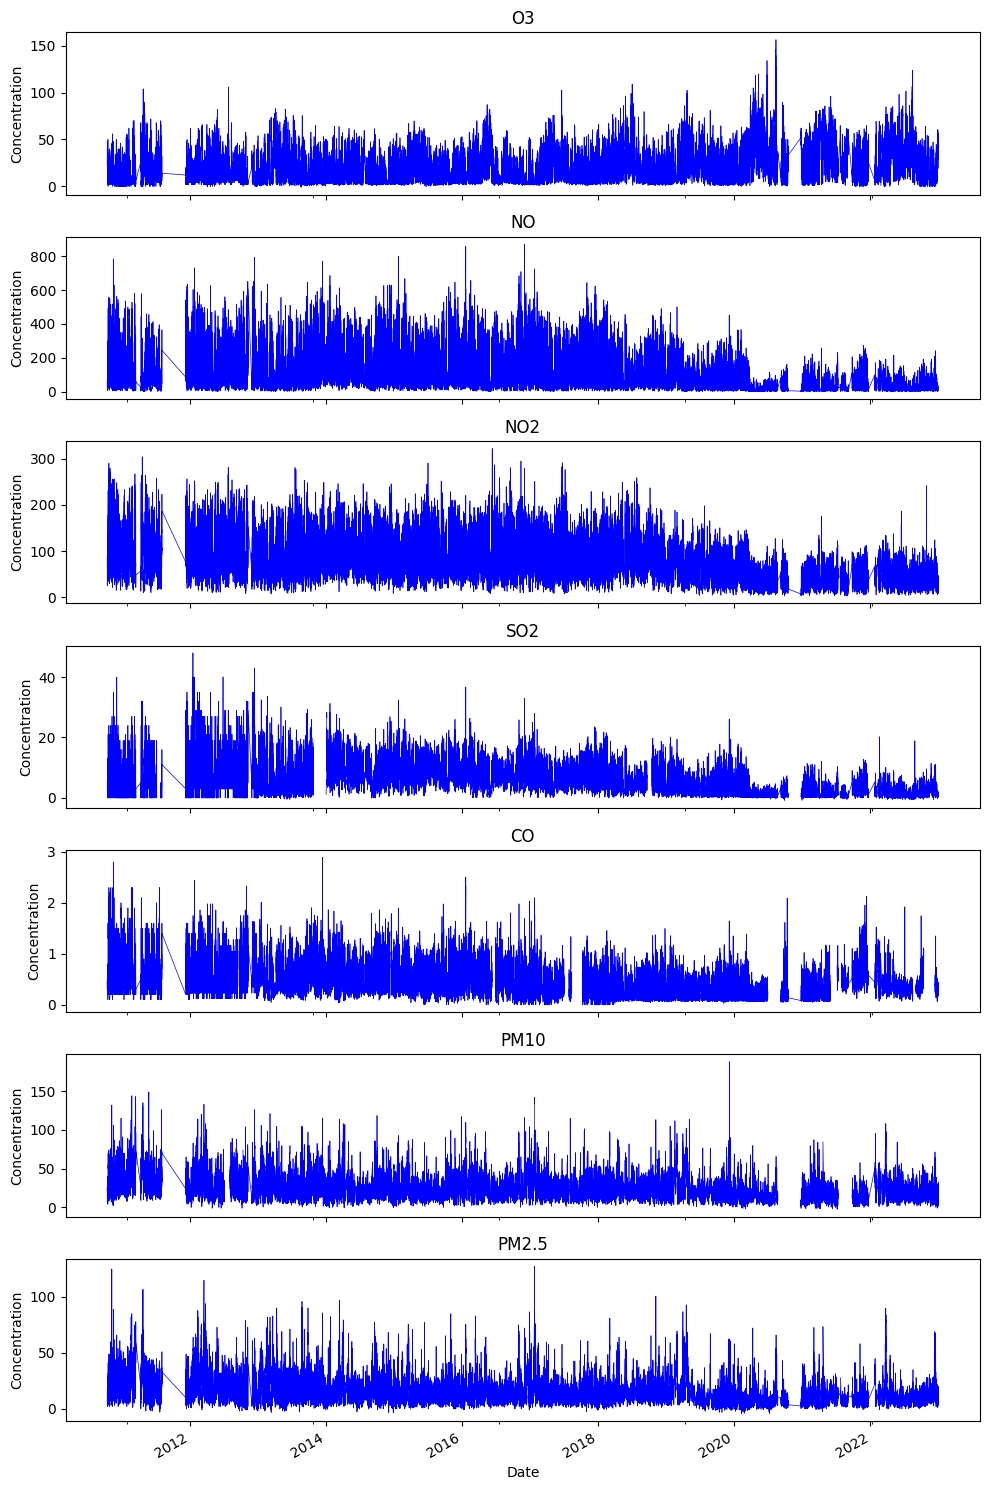

In [79]:
# pollutants visualization
pollutants = ['O3', 'NO', 'NO2', 'SO2', 'CO', 'PM10', 'PM2.5']
# create the figure to show the pollutants variation
fig, axes = plt.subplots(nrows=len(pollutants), ncols=1, figsize=(10, 15), sharex=True)

for i, pollutant in enumerate(pollutants):
    df[pollutant].plot(ax=axes[i], title=pollutant, color='blue', linewidth=0.5)
    axes[i].set_ylabel('Concentration')

axes[-1].set_xlabel('Date')

plt.tight_layout()

plt.show()

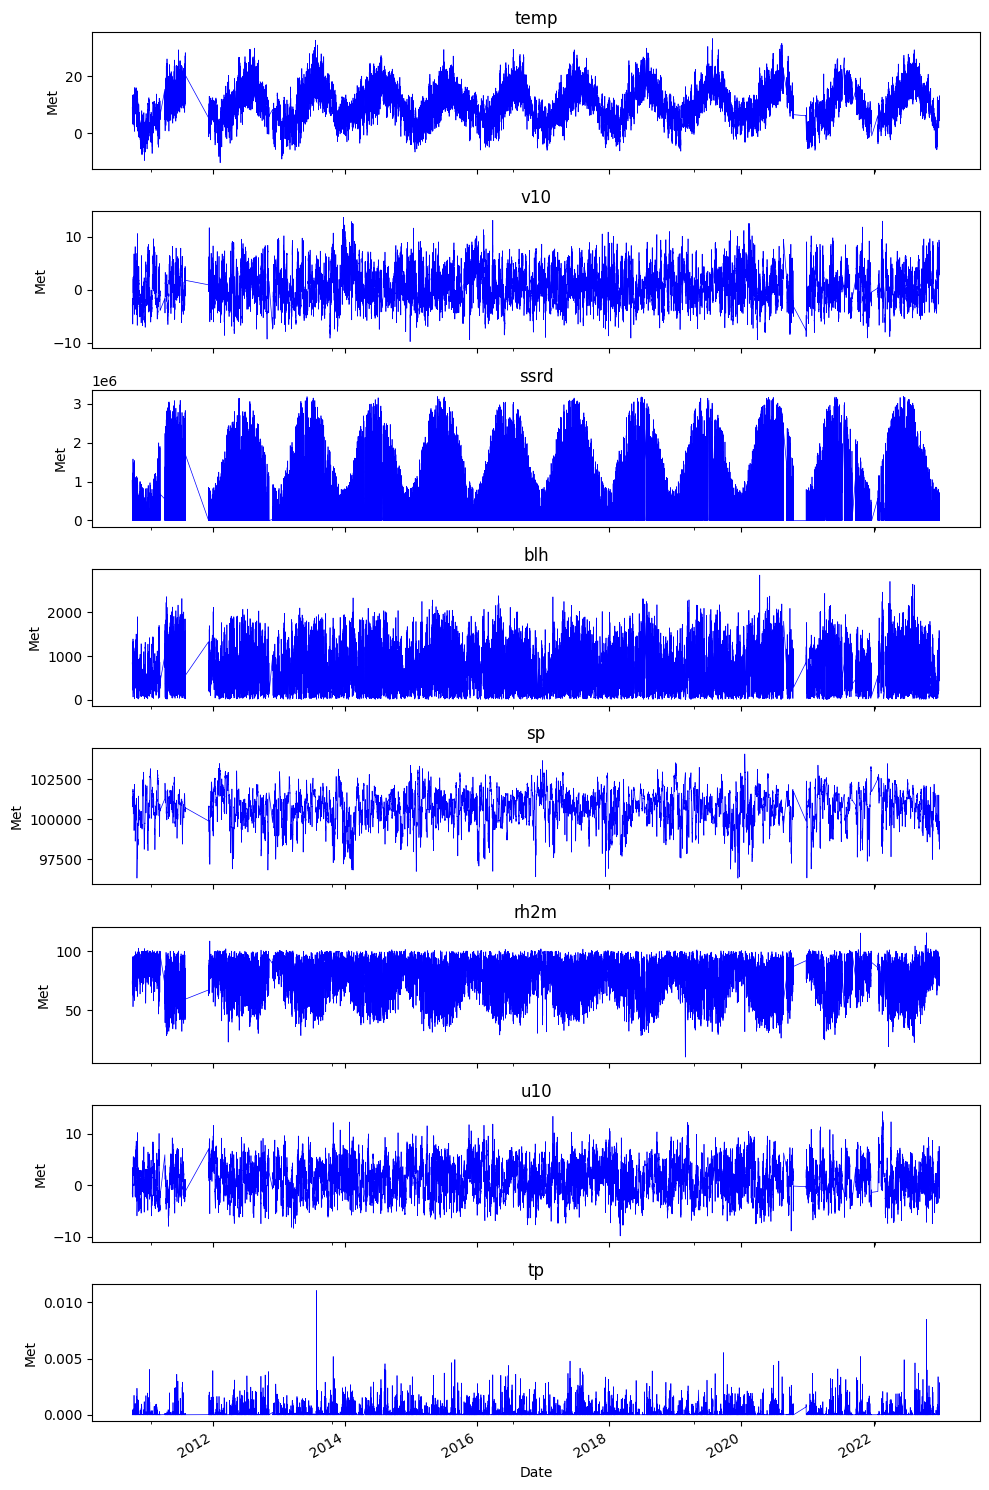

In [81]:
# pollutants visualization
pollutants = [ 'temp', 'v10', 'ssrd', 'blh','sp', 'rh2m',  'u10', 'tp']

fig, axes = plt.subplots(nrows=len(pollutants), ncols=1, figsize=(10, 15), sharex=True)

for i, pollutant in enumerate(pollutants):
    df[pollutant].plot(ax=axes[i], title=pollutant, color='blue', linewidth=0.5)
    axes[i].set_ylabel('Met')

axes[-1].set_xlabel('Date')

plt.tight_layout()

plt.show()

<font size="4" color="blue">Question: Is the change in concentration due to meteorological factors or caused by human activities (such as emissions)?</font>


$$C = C_{met} + C_{emission}$$

<font size="6">Step2: AutoML-based weather normalisation</font>

<font size="4">
Based on what we learned in the morning, we now understand that weather normalization can be roughly understood as a two-step process:
<ul>
  <li>The first step is to establish the relationship between pollutant concentration and meteorological as well as time parameters (emissions) - using machine learning.</li>
  <li>The second step is to normalize the meteorological parameters in order to eliminate the influence of weather on concentration.</li>
</ul>
</font>


<font size="4">2.1: AutoML </font>

<font size="4">In this section, we will use the AutoML (has already been embedded in normet) to build the relationship between concentration and variables</font>


<font size="4" color='green'> 2.1.1 normet function - [prepare_data]: this function will help you to prepare the data for AutoML training </font>
    """

    Parameters:
        df (pandas.DataFrame):: Input DataFrame containing the dataset.
        value (str): Name of the target variable.
        feature_names (list): List of feature names.
        na_rm (bool, optional): Whether to remove missing values. Default is True.
        split_method (str, optional): Method for splitting data ('random' or 'time_series'). Default is 'random'.
        replace (bool, optional): Whether to replace existing date variables. Default is False.
        fraction (float, optional): Fraction of the dataset to be used for training. Default is 0.75.
        seed (int, optional): Seed for random operations. Default is 7654321.

    Returns:
        DataFrame: Prepared DataFrame with cleaned data and split into training and testing sets.
    """

In [91]:
# now we choose all the meteorological parameters in df as the features, 
# the normet will automatically help us to generate the time variables.

df1a=nm.prepare_data(df, value='PM2.5', feature_names=[ 'temp', 'v10', 'ssrd', 'blh',
       'sp', 'rh2m', 't2m', 'u10', 'tp'], split_method='random',  fraction=0.75, seed=7654321)

df1a.head()

,rowid,tp,ssrd,sp,u10,temp,rh2m,blh,v10,date,value,date_unix,day_julian,weekday,hour,set
0,0,0.0,1032762.56,101350.99,-1.647905,9.0,74.64452,823.39966,-2.915381,2010-10-13 12:00:00,16.0,1.286971e+09,286,3,12,training
1,1,0.0,883327.20,101301.67,-1.395934,9.0,72.99228,834.39100,-3.091130,2010-10-13 13:00:00,10.0,1.286975e+09,286,3,13,testing
2,2,0.0,1038951.25,101267.99,-1.281452,8.8,72.24144,857.62600,-3.433254,2010-10-13 14:00:00,10.0,1.286978e+09,286,3,14,training
3,3,0.0,710545.70,101246.85,-1.228140,8.6,71.95577,850.04333,-3.658799,2010-10-13 15:00:00,10.0,1.286982e+09,286,3,15,training
4,4,0.0,333183.62,101236.37,-1.210743,8.4,71.84961,846.91284,-3.668172,2010-10-13 16:00:00,12.0,1.286986e+09,286,3,16,training


<font size="4" color="blue">Question: meaning of date_unix, day_julian, weekday, hour?</font>

date_unix refers to the UNIX timestamp, also known as Epoch time. It represents the number of seconds that have passed since 00:00:00 UTC on January 1, 1970. This time format is widely used in operating systems and programming languages to represent specific points in time.


day_julian refers to the Julian day. In this context, it usually represents the day of the year. For instance, day_julian = 1 corresponds to January 1st, and day_julian = 365 corresponds to December 31st in a non-leap year.

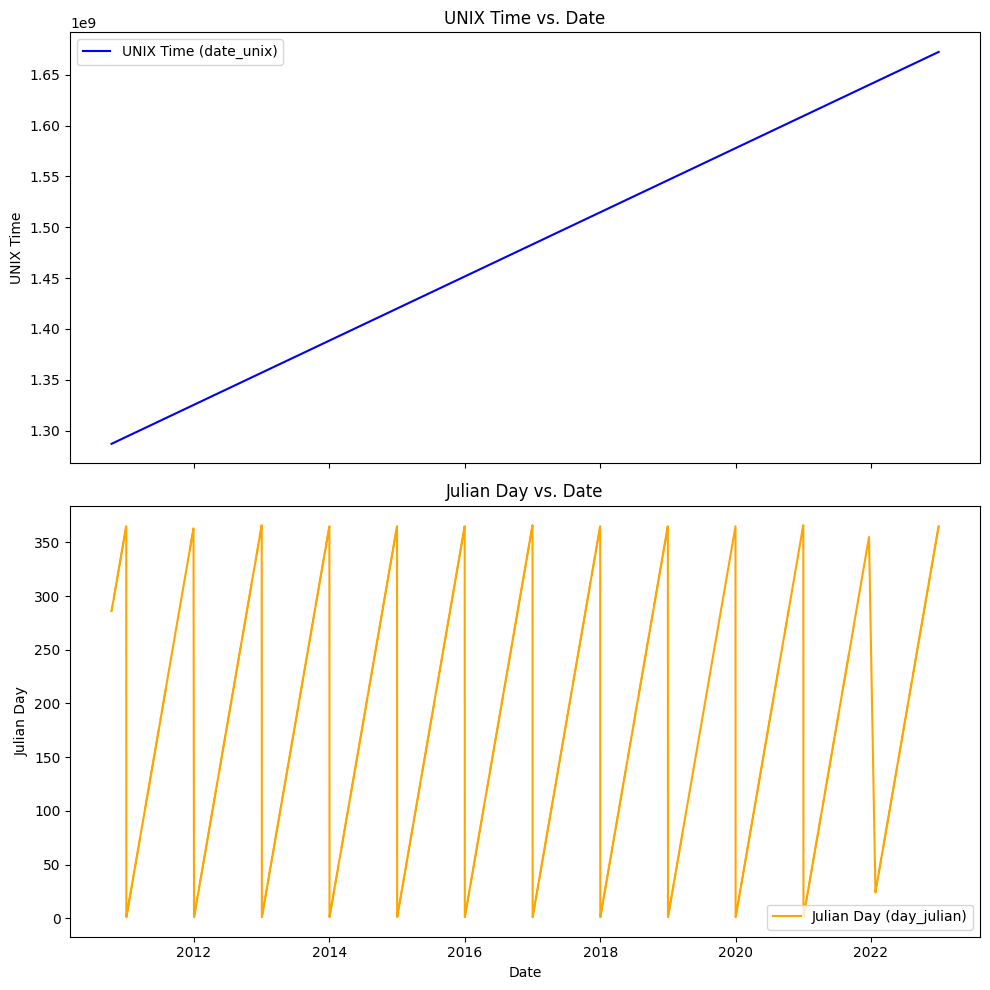

In [98]:
# let us create a figure for day_julian and date_unix
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)
# UNIX Time vs. Date
axes[0].plot(df1a['date'], df1a['date_unix'], label='UNIX Time (date_unix)', color='blue')
axes[0].set_ylabel('UNIX Time')
axes[0].set_title('UNIX Time vs. Date')
axes[0].legend()
# Julian Day vs. Date
axes[1].plot(df1a['date'], df1a['day_julian'], label='Julian Day (day_julian)', color='orange')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Julian Day')
axes[1].set_title('Julian Day vs. Date')
axes[1].legend()
plt.tight_layout()
plt.show()

<font size="4" color="blue">date_unix represents the year trend</font>

<font size="4" color="blue">date_julian represents the seasonal trend</font>

<font size="4" color='green'> 2.1.2 normet function - [train_model]: train the regression model using AutoML </font>

      """
    Parameters:
        df (pandas.DataFrame): Input DataFrame containing the dataset.
        value (str, optional): Name of the target variable. Default is 'value'.
        variables (list of str, optional): List of feature variables. Default is None.

    Keyword Parameters:
        model_config (dict, optional): Configuration dictionary for model training parameters.
        seed (int, optional): Random seed for reproducibility. Default is 7654321.
        verbose (bool, optional): If True, print progress messages. Default is True.

    Returns:
        object: Trained ML model object.

    Raises:
    ValueError: If `variables` contains duplicates or if any `variables` are not present in the DataFrame.
    """

In [101]:
# now we choose all the meteorological parameters and time variables as the input feature. 
# use the default model configuration
    # default_model_config = {
    #     'time_budget': 60,                     # Total running time in seconds
    #     'metric': 'r2',                        # Primary metric for regression, 'mae', 'mse', 'r2', 'mape',...
    #     'estimator_list': ["rf"],            # List of ML learners: "lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"
    #     'task': 'regression',                  # Task type
    #     'eval_method': 'auto',                 # A string of resampling strategy, one of ['auto', 'cv', 'holdout'].
    #     'verbose': True                     # Print progress messages
    # }
automl=nm.train_model(df1a,variables=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m' , 'date_unix', 'day_julian', 'weekday', 'hour'],model_config=None);

2024-08-18 03:56:41 : Training AutoML...
2024-08-18 03:57:44 : Best model is rf with best model parameters of {'n_estimators': 115, 'max_features': 0.6169134345349816, 'max_leaves': 16937}


<font size="3" color='green'> normet function - [modStats]: calculates statistics for model evaluation based on provided data </font>

    """
    Parameters:
        df (pandas.DataFrame): Input DataFrame containing the dataset.
        model (object): Trained ML model.
        set (str, optional): Set type for which statistics are calculated ('training', 'testing', or 'all'). Default is None.
        statistic (list of str, optional): List of statistics to calculate. Default is ["n", "FAC2", "MB", "MGE", "NMB", "NMGE", "RMSE", "r", "COE", "IOA", "R2"].

    Returns:
        pd.DataFrame: DataFrame containing calculated statistics.

    Example:
        >>> df = pd.read_csv('timeseries_data.csv')
        >>> model = train_model(df, 'target', feature_names)
        >>> stats = modStats(df, model, set='testing')
    """

In [104]:
mod_stats=nm.modStats(df1a,automl)
mod_stats

,n,FAC2,MB,MGE,NMB,NMGE,RMSE,r,p_level,COE,IOA,R2,set
0,66686,0.985199,0.032772,1.370026,0.002060,0.086136,1.952299,0.988885,***,0.835605,0.917802,0.977893,training
1,22228,0.945609,0.031619,3.321828,0.001975,0.207500,4.913157,0.909687,***,0.601141,0.800571,0.827531,testing
2,88914,0.975302,0.032484,1.857965,0.002039,0.116624,2.982158,0.969816,***,0.777025,0.888512,0.940544,all


### index name and meaning

1. **n**  
   **Full Name**: Number of Data Points  
   **Explanation**: The number of data points used in model evaluation, i.e., the sample size.

2. **FAC2**  
   **Full Name**: Factor of Two  
   **Explanation**: The fraction of predictions that are within a factor of two of the observations. This metric assesses the accuracy of the model's predictions.

3. **MB**  
   **Full Name**: Mean Bias  
   **Explanation**: The average difference between predicted and observed values, indicating whether the model systematically overestimates or underestimates.

4. **MGE**  
   **Full Name**: Mean Gross Error  
   **Explanation**: The average absolute error between predictions and observations, reflecting the overall error level of the model.

5. **NMB**  
   **Full Name**: Normalized Mean Bias  
   **Explanation**: The mean bias normalized as a percentage of the observed values, useful for comparing bias across datasets of different magnitudes.

6. **NMGE**  
   **Full Name**: Normalized Mean Gross Error  
   **Explanation**: The mean gross error normalized as a percentage of the observed values, used to assess the relative error of the model.

7. **RMSE**  
   **Full Name**: Root Mean Square Error  
   **Explanation**: The square root of the average squared differences between predicted and observed values. It is a common measure of model error; lower values indicate better performance.

8. **r**  
   **Full Name**: Pearson Correlation Coefficient  
   **Explanation**: The linear correlation coefficient between predicted and observed values, ranging from -1 to 1, where 1 indicates perfect positive correlation.

9. **p_level**  
   **Full Name**: Significance Level (p-value)  
   **Explanation**: A small probability value used to assess whether the results are statistically significant, typically used alongside the correlation coefficient `r`.

10. **COE**  
    **Full Name**: Coefficient of Efficiency  
    **Explanation**: A measure of the model's predictive accuracy, often used in conjunction with the mean squared error (MSE). The closer the COE is to 1, the better the model performs.

11. **IOA**  
    **Full Name**: Index of Agreement  
    **Explanation**: A metric that assesses the agreement between predicted and observed values, ranging from 0 to 1, with 1 indicating perfect agreement.

12. **R2**  
    **Full Name**: Coefficient of Determination (R-squared)  
    **Explanation**: Represents the proportion of the variance in the observed data that is explained by the model. Values range from 0 to 1, with 1 indicating perfect fit.


<font size="4" ><b>change the automl config</b></font>

In [169]:
# change model config
new_model_config = {
    'time_budget': 200,                     # Total running time in seconds
    'metric': 'r2',                        # Primary metric for regression, 'mae', 'mse', 'r2', 'mape',...
    'estimator_list': ["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"],            # List of ML learners: "lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"
    'task': 'regression',                  # Task type
    'eval_method': 'cv',                 # A string of resampling strategy, one of ['auto', 'cv', 'holdout'].
    'verbose': True                     # Print progress messages
}

In [106]:
automl=nm.train_model(df1a,variables=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m' , 'date_unix', 'day_julian', 'weekday', 'hour'],model_config=new_model_config);

2024-08-18 04:00:49 : Training AutoML...
2024-08-18 04:04:16 : Best model is lgbm with best model parameters of {'n_estimators': 48, 'num_leaves': 1217, 'min_child_samples': 19, 'learning_rate': 0.17583852694964577, 'log_max_bin': 9, 'colsample_bytree': 1.0, 'reg_alpha': 0.003604745448841198, 'reg_lambda': 0.06152256910729002}


In [107]:
mod_stats=nm.modStats(df1a,automl)
mod_stats

,n,FAC2,MB,MGE,NMB,NMGE,RMSE,r,p_level,COE,IOA,R2,set
0,66686,0.985064,-0.000037,1.349959,-0.000002,0.084874,1.848854,0.987778,***,0.838013,0.919006,0.975705,training
1,22228,0.949793,-0.033494,3.202411,-0.002092,0.200041,4.614289,0.916721,***,0.615480,0.807740,0.840378,testing
2,88914,0.976247,-0.008401,1.813062,-0.000527,0.113805,2.808293,0.970690,***,0.782414,0.891207,0.942239,all


In [108]:
best_model = automl.best_estimator
best_config = automl.best_config
print("Best model:", best_model)
print("Best model parameters:", best_config)

Best model: lgbm
Best model parameters: {'n_estimators': 48, 'num_leaves': 1217, 'min_child_samples': 19, 'learning_rate': 0.17583852694964577, 'log_max_bin': 9, 'colsample_bytree': 1.0, 'reg_alpha': 0.003604745448841198, 'reg_lambda': 0.06152256910729002}


In [109]:
automl.best_result

{'pred_time': 1.5789569031389126e-06,
 'wall_clock_time': 65.51165413856506,
 'metric_for_logging': {'pred_time': 1.5789569031389126e-06},
 'val_loss': 0.18126974616162347,
 'training_iteration': 1,
 'config': {'n_estimators': 48,
  'num_leaves': 1217,
  'min_child_samples': 19,
  'learning_rate': 0.17583852694964577,
  'log_max_bin': 9,
  'colsample_bytree': 1.0,
  'reg_alpha': 0.003604745448841198,
  'reg_lambda': 0.06152256910729002},
 'config/n_estimators': 48,
 'config/num_leaves': 1217,
 'config/min_child_samples': 19,
 'config/learning_rate': 0.17583852694964577,
 'config/log_max_bin': 9,
 'config/colsample_bytree': 1.0,
 'config/reg_alpha': 0.003604745448841198,
 'config/reg_lambda': 0.06152256910729002,
 'experiment_tag': 'exp',
 'time_total_s': 39.94852590560913}

<font size="4" ><b>feature importance</b></font>

[1117 6109 2627 6190 2914 5263 5540 6892 5629 5918 7046 3123]
['weekday' 'u10' 'tp' 'v10' 'ssrd' 'blh' 'temp' 'sp' 'rh2m' 'date_unix'
 'day_julian' 'hour']


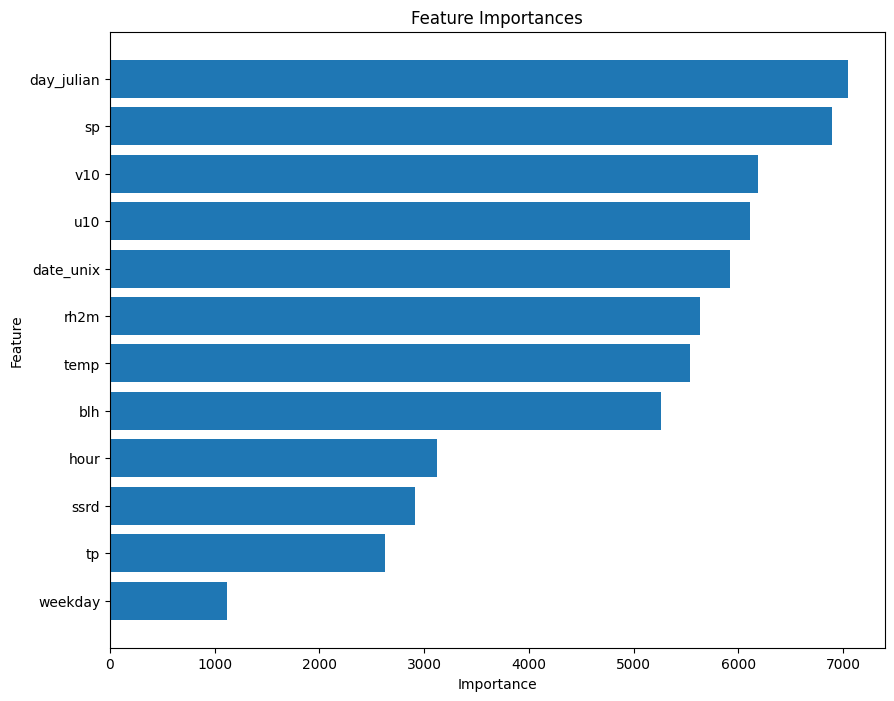

In [110]:
importances = automl.feature_importances_
feature_names = automl.feature_names_in_
indices = np.argsort(importances)
print(importances)
print(feature_names)
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

<font size="4">2.2: weather normalization process </font>

<font size="4" color='green'> 2.2.1 normet function - [normalise]: this function will help you normalises the dataset using the trained model </font>
  
"""

    Parameters:
        df (pandas.DataFrame): Input DataFrame containing the dataset.
        model (object): Trained ML model.
        feature_names (list of str): List of feature names.
        variables_resample (list of str): List of resampling variables.
        n_samples (int, optional): Number of samples to normalise. Default is 300.
        replace (bool, optional): Whether to replace existing data. Default is True.
        aggregate (bool, optional): Whether to aggregate results. Default is True.
        seed (int, optional): Random seed. Default is 7654321.
        n_cores (int, optional): Number of CPU cores to use. Default is total CPU cores minus one.
        weather_df (pandas.DataFrame, optional): DataFrame containing weather data for resampling. Default is None.
        verbose (bool, optional): Whether to print progress messages. Default is True.

    Returns:
        pd.DataFrame: DataFrame containing normalised predictions.

    Example:
        >>> data = {
        ...     'date': pd.date_range(start='2020-01-01', periods=5, freq='D'),
        ...     'feature1': [1, 2, 3, 4, 5],
        ...     'feature2': [5, 4, 3, 2, 1],
        ...     'value': [2, 3, 4, 5, 6]
        ... }
        >>> df = pd.DataFrame(data)
        >>> feature_names = ['feature1', 'feature2']
        >>> model = train_model(df, value='value', variables=feature_names)
        >>> variables_resample = ['feature1', 'feature2']
        >>> normalised_df = normalise(df, model, feature_names, variables_resample)
    """

In [112]:
# normalizaiton: select the feature_names we trained in the automl model
# then select the normalization variables - the feature you want to 'remove'
start_time = time.time()
df_dew1=nm.normalise(df1a, automl, feature_names=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m','date_unix', 'day_julian', 'weekday','hour'],
                          variables_resample= ['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m'],
                          n_samples=100)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

2024-08-18 04:09:16 : Normalising the dataset using the trained model in parallel.
2024-08-18 04:09:42 : Aggregating 100 predictions...
Execution time: 26.39 seconds


                     observed  normalised
date                                     
2010-10-13 12:00:00      16.0   26.483235
2010-10-13 13:00:00      10.0   27.475034
2010-10-13 14:00:00      10.0   29.908030
2010-10-13 15:00:00      10.0   27.967847
2010-10-13 16:00:00      12.0   27.914274


<Axes: xlabel='date'>

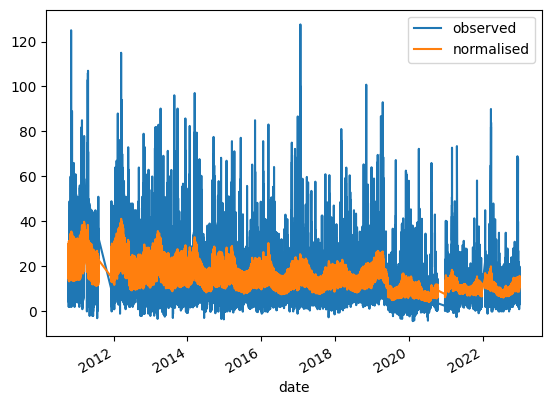

In [113]:
print(df_dew1.head())
df_dew1.plot()

<font size="5">change shuffle number</font>

<font size="4" color='blue'>Question: Based on this morning's and today's lessons, do you think the shuffle number could affect the results of normalization?</font>


In [126]:
start_time = time.time()
df_dew2=nm.normalise(df1a,automl,feature_names=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m','date_unix', 'day_julian', 'weekday',
       'hour'],variables_resample=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m'],n_samples=200)
end_time = time.time()


execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

2024-08-18 04:21:35 : Normalising the dataset using the trained model in parallel.
2024-08-18 04:22:01 : Aggregating 200 predictions...
Execution time: 26.83 seconds


In [127]:
start_time = time.time()
df_dew3=nm.normalise(df1a,automl,feature_names=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m','date_unix', 'day_julian', 'weekday',
       'hour'],variables_resample=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m'],n_samples=300)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

2024-08-18 04:22:02 : Normalising the dataset using the trained model in parallel.


/Users/user/miniconda3/envs/weather_nor/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/user/miniconda3/envs/weather_nor/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/user/miniconda3/envs/weather_nor/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/user/miniconda3/envs/weather_nor/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given 

2024-08-18 04:22:48 : Aggregating 300 predictions...
Execution time: 47.02 seconds


In [128]:
start_time = time.time()
df_dew6=nm.normalise(df1a,automl,feature_names=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m','date_unix', 'day_julian', 'weekday',
       'hour'],variables_resample=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m'],n_samples=600)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

2024-08-18 04:22:49 : Normalising the dataset using the trained model in parallel.
2024-08-18 04:24:07 : Aggregating 600 predictions...
Execution time: 80.17 seconds


In [129]:
start_time = time.time()
df_dew10=nm.normalise(df1a,automl,feature_names=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m','date_unix', 'day_julian', 'weekday',
       'hour'],variables_resample=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m'],n_samples=1000)
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

2024-08-18 04:24:09 : Normalising the dataset using the trained model in parallel.
2024-08-18 04:26:20 : Aggregating 1000 predictions...
Execution time: 133.40 seconds


<font size="4" color='blue'>time increases with shuffle number</font>

In [130]:
print(df_dew2.head())
print(df_dew3.head())
print(df_dew6.head())
print(df_dew10.head())

                     observed  normalised
date                                     
2010-10-13 12:00:00      16.0   26.309780
2010-10-13 13:00:00      10.0   27.371362
2010-10-13 14:00:00      10.0   28.821431
2010-10-13 15:00:00      10.0   27.961997
2010-10-13 16:00:00      12.0   28.108118
                     observed  normalised
date                                     
2010-10-13 12:00:00      16.0   26.497849
2010-10-13 13:00:00      10.0   28.017306
2010-10-13 14:00:00      10.0   28.538298
2010-10-13 15:00:00      10.0   28.353885
2010-10-13 16:00:00      12.0   28.617780
                     observed  normalised
date                                     
2010-10-13 12:00:00      16.0   27.248038
2010-10-13 13:00:00      10.0   28.027353
2010-10-13 14:00:00      10.0   28.712081
2010-10-13 15:00:00      10.0   28.514310
2010-10-13 16:00:00      12.0   28.820686
                     observed  normalised
date                                     
2010-10-13 12:00:00      16.0   27

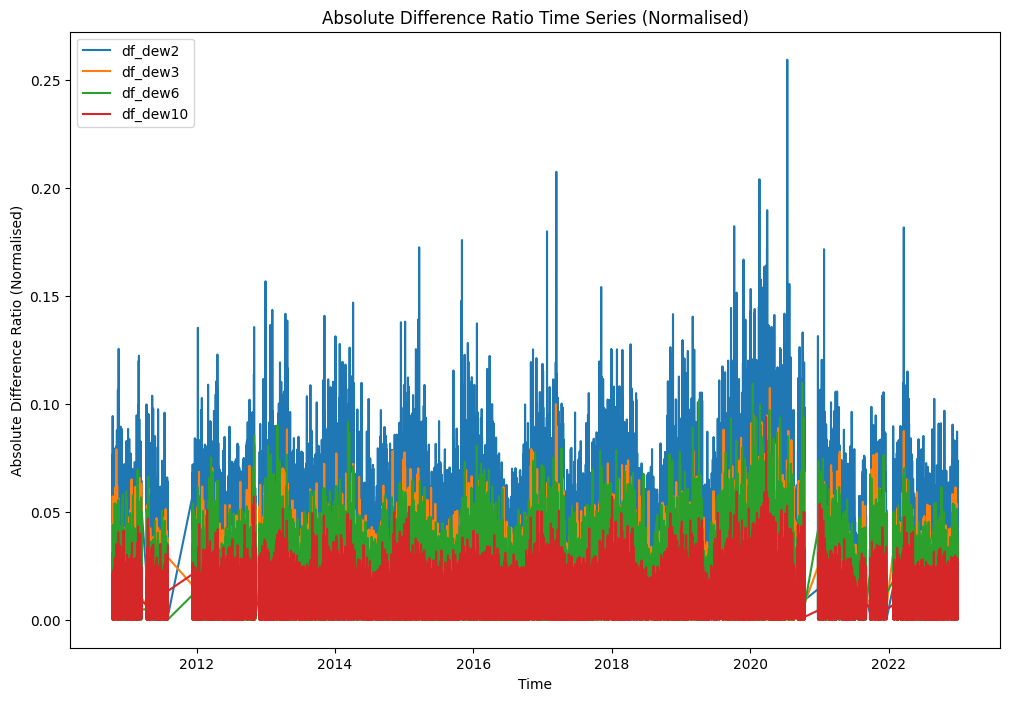

In [132]:
# create a figure to show the difference under different shuffle number
dfs = [df_dew1, df_dew2, df_dew3, df_dew6, df_dew10]
labels = ['df_dew2', 'df_dew3', 'df_dew6', 'df_dew10']
plt.figure(figsize=(12, 8))
for i in range(1, len(dfs)):
    diff = np.abs(dfs[i]['normalised'] - dfs[i-1]['normalised']) / np.abs(dfs[i-1]['normalised'])
    plt.plot(diff.index, diff.values, label=labels[i-1])

plt.xlabel('Time')
plt.ylabel('Absolute Difference Ratio (Normalised)')
plt.title('Absolute Difference Ratio Time Series (Normalised)')
plt.legend(loc='upper left')
plt.show()

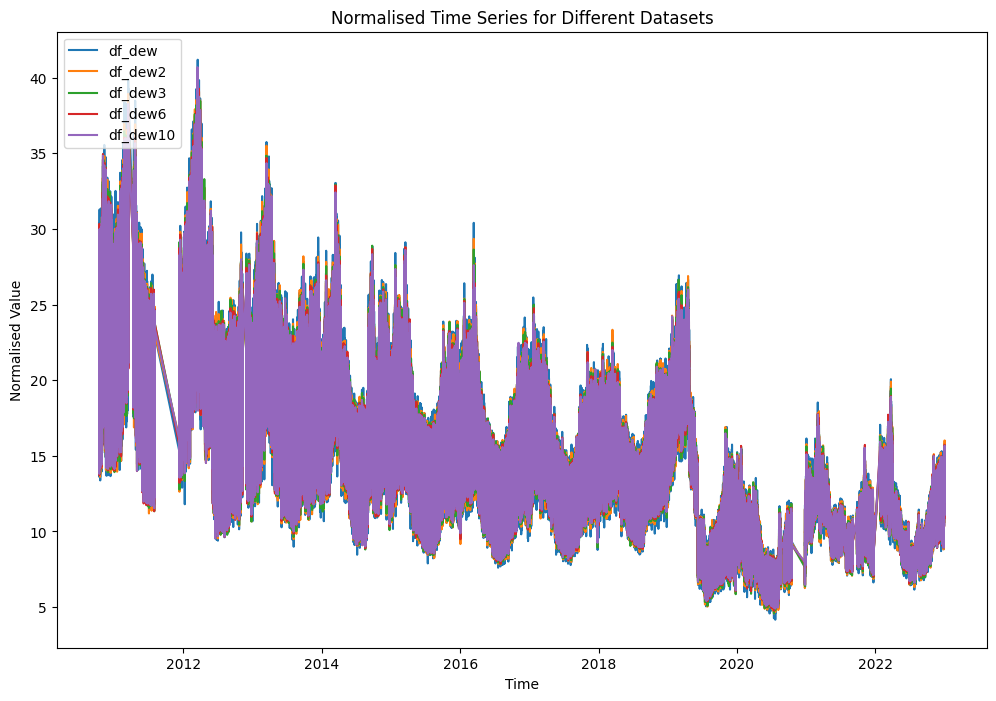

In [138]:
# create a figure to show the normalized data under different shuffle number
dfs = [df_dew1, df_dew2, df_dew3,  df_dew6, df_dew10]

labels = ['df_dew', 'df_dew2', 'df_dew3','df_dew6', 'df_dew10']

plt.figure(figsize=(12, 8))

for i, df_single in enumerate(dfs):
    plt.plot(df_single.index, df_single['normalised'], label=labels[i])

plt.xlabel('Time')
plt.ylabel('Normalised Value')
plt.title('Normalised Time Series for Different Datasets')
plt.legend(loc='upper left')
plt.show()

<font size="4">2.3: one- step weather normalization process </font>

<font size="4" color='green'>  normet function - [do_all]: Conducts data preparation, model training, and normalisation, returning the transformed dataset and model statistics </font>

"""

    This function performs the entire pipeline from data preparation to model training and normalisation using
    specified parameters and returns the transformed dataset along with model statistics.

    Parameters:
        df (pandas.DataFrame): Input DataFrame containing the dataset.
        model (object, optional): Pre-trained model to use for decomposition. If None, a new model will be trained. Default is None.
        value (str): Name of the target variable.
        feature_names (list of str): List of feature names.
        variables_resample (list of str): List of variables for normalisation.
        split_method (str, optional): Method for splitting data ('random' or 'time_series'). Default is 'random'.
        fraction (float, optional): Fraction of the dataset to be used for training. Default is 0.75.
        model_config (dict, optional): Configuration dictionary for model training parameters.
        n_samples (int, optional): Number of samples for normalisation. Default is 300.
        seed (int, optional): Seed for random operations. Default is 7654321.
        n_cores (int, optional): Number of CPU cores to be used for normalisation. Default is total CPU cores minus one.
        weather_df (pandas.DataFrame, optional): DataFrame containing weather data for resampling. Default is None.
        verbose (bool, optional): Whether to print progress messages. Default is True.
        return_model (bool, optional): Whether to return trained model. Default is False.

    Returns:
        if return_model is True:
            - df_dew (pandas.DataFrame): Transformed dataset with normalised values.
            - mod_stats (pandas.DataFrame): DataFrame containing model statistics.
            - model: Trained ML model object.
        if return_model is False:
            - df_dew (pandas.DataFrame): Transformed dataset with normalised values.
            - mod_stats (pandas.DataFrame): DataFrame containing model statistics.
 

    Example:
        >>> df = pd.read_csv('timeseries_data.csv')
        >>> value = 'target'
        >>> feature_names = ['feature1', 'feature2', 'feature3']
        >>> variables_resample = ['feature1', 'feature2']
        >>> df_dew, mod_stats = do_all(df, value, feature_names, variables_resample)
    """

In [140]:
df_dew_all, mod_stats_all=nm.do_all(df,value='PM2.5',feature_names=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m','date_unix', 'day_julian', 'weekday',
       'hour'],variables_resample=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m'],model_config=new_model_config,n_samples=300)

2024-08-18 04:33:40 : Training AutoML...
2024-08-18 04:37:07 : Best model is lgbm with best model parameters of {'n_estimators': 48, 'num_leaves': 1217, 'min_child_samples': 19, 'learning_rate': 0.17583852694964577, 'log_max_bin': 9, 'colsample_bytree': 1.0, 'reg_alpha': 0.003604745448841198, 'reg_lambda': 0.06152256910729002}
2024-08-18 04:37:07 : Normalising the dataset using the trained model in parallel.
2024-08-18 04:37:58 : Aggregating 300 predictions...


       n      FAC2        MB       MGE       NMB      NMGE      RMSE  \
0  66686  0.985064 -0.000037  1.349959 -0.000002  0.084874  1.848854   
1  22228  0.949793 -0.033494  3.202411 -0.002092  0.200041  4.614289   
2  88914  0.976247 -0.008401  1.813062 -0.000527  0.113805  2.808293   

          r p_level       COE       IOA        R2       set  
0  0.987778     ***  0.838013  0.919006  0.975705  training  
1  0.916721     ***  0.615480  0.807740  0.840378   testing  
2  0.970690     ***  0.782414  0.891207  0.942239       all  


<Axes: xlabel='date'>

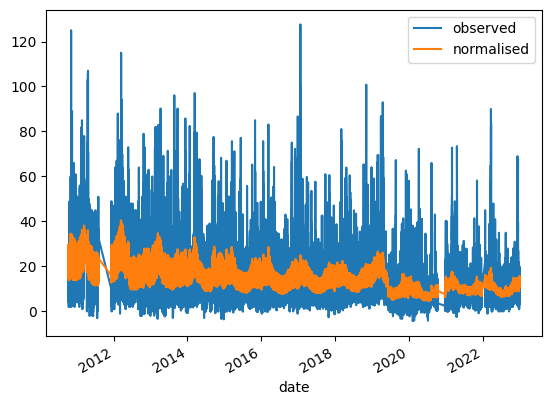

In [141]:
print(mod_stats_all)
df_dew_all.plot()

<font size="4">2.4: the meteorological parameters contributed concentration </font>

In [143]:
df_dew_all['met']=df_dew_all['observed']-df_dew_all['normalised']

<Axes: xlabel='date'>

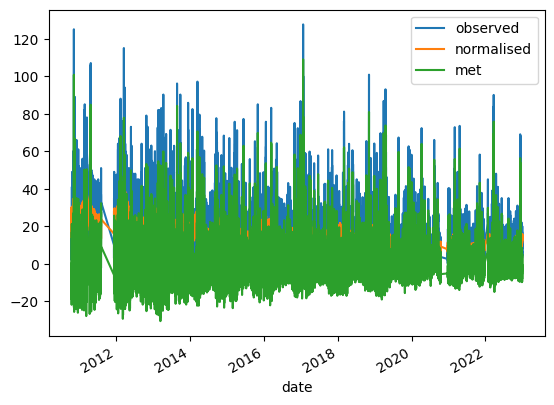

In [144]:
df_dew_all.plot()

<font size="6">Step3: Normalized data visualization</font>


/var/folders/8p/ny4s42v97yz7qg_ysw7z_rm00000gp/T/ipykernel_12731/3335804546.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_dew_all,x=df_dew_all.index.hour, y=df_dew_all['observed'], ax=axes[0], showfliers=False, palette="Blues").set(xlabel='Hour of day',ylabel='Abundance')
/var/folders/8p/ny4s42v97yz7qg_ysw7z_rm00000gp/T/ipykernel_12731/3335804546.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_dew_all,x=df_dew_all.index.hour, y=df_dew_all['normalised'], ax=axes[1], showfliers=False, palette="Blues").set(xlabel='Hour of day',ylabel='Abundance')


Text(0.5, 1.0, 'normalised')

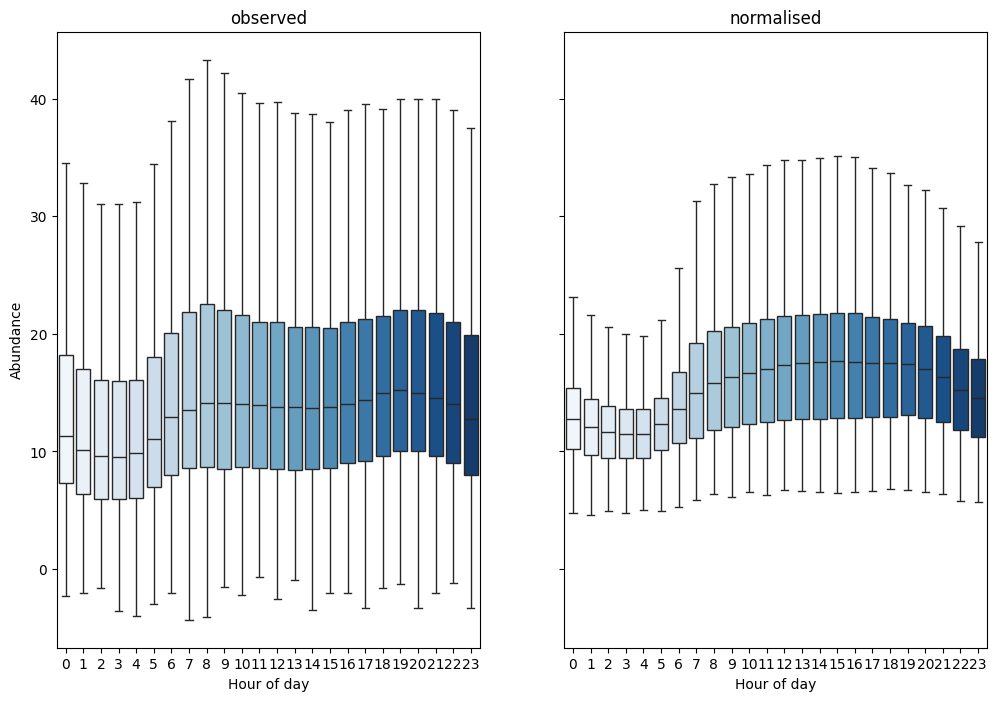

In [147]:
fig, axes = plt.subplots(1,2,figsize=(12,8),sharey=True)
sns.boxplot(data=df_dew_all,x=df_dew_all.index.hour, y=df_dew_all['observed'], ax=axes[0], showfliers=False, palette="Blues").set(xlabel='Hour of day',ylabel='Abundance')
sns.boxplot(data=df_dew_all,x=df_dew_all.index.hour, y=df_dew_all['normalised'], ax=axes[1], showfliers=False, palette="Blues").set(xlabel='Hour of day',ylabel='Abundance')
axes[0].set_title('observed')
axes[1].set_title('normalised')

/var/folders/8p/ny4s42v97yz7qg_ysw7z_rm00000gp/T/ipykernel_12731/4180384292.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_dew_all,x=df_dew_all.index.month, y=df_dew_all['observed'], ax=axes[0], showfliers=False, palette="Blues").set(xlabel='Month',ylabel='Abundance')
/var/folders/8p/ny4s42v97yz7qg_ysw7z_rm00000gp/T/ipykernel_12731/4180384292.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_dew_all,x=df_dew_all.index.month, y=df_dew_all['normalised'], ax=axes[1], showfliers=False, palette="Blues").set(xlabel='Month',ylabel='Abundance')


Text(0.5, 1.0, 'normalised')

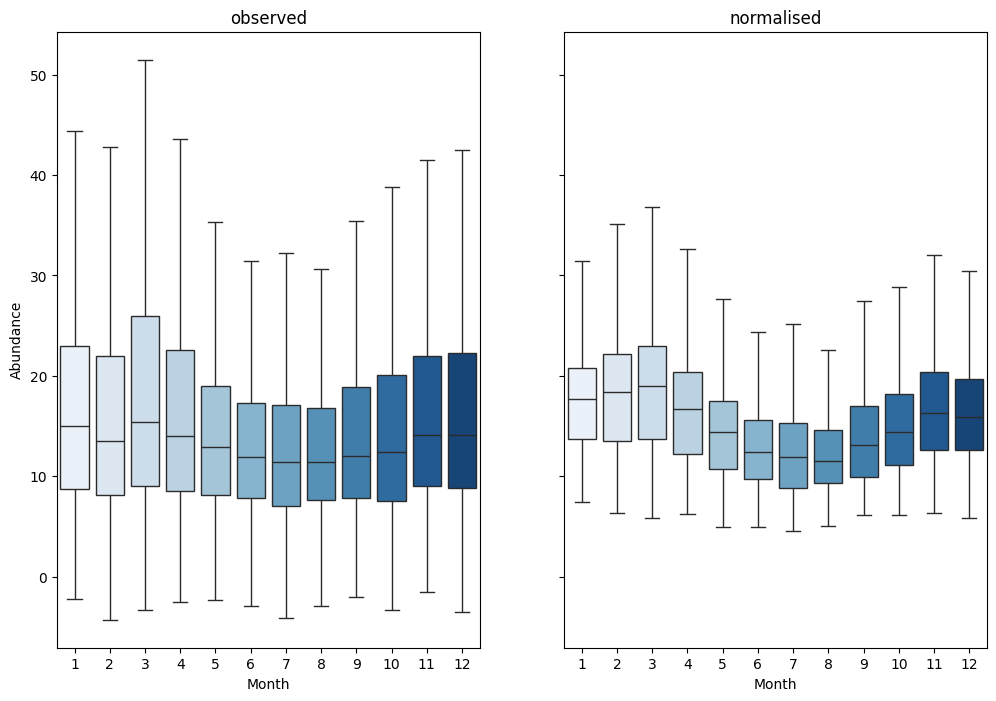

In [148]:
fig, axes = plt.subplots(1,2,figsize=(12,8),sharey=True)
sns.boxplot(data=df_dew_all,x=df_dew_all.index.month, y=df_dew_all['observed'], ax=axes[0], showfliers=False, palette="Blues").set(xlabel='Month',ylabel='Abundance')
sns.boxplot(data=df_dew_all,x=df_dew_all.index.month, y=df_dew_all['normalised'], ax=axes[1], showfliers=False, palette="Blues").set(xlabel='Month',ylabel='Abundance')
axes[0].set_title('observed')
axes[1].set_title('normalised')

/var/folders/8p/ny4s42v97yz7qg_ysw7z_rm00000gp/T/ipykernel_12731/2275968192.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df_subset,x=combined_df_subset.index.hour, y=combined_df_subset['observed'], ax=axes[0,0], showfliers=False, palette="Blues").set(xlabel='Hour of day',ylabel='Abundance')
/var/folders/8p/ny4s42v97yz7qg_ysw7z_rm00000gp/T/ipykernel_12731/2275968192.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df_subset,x=combined_df_subset.index.month, y=combined_df_subset['observed'], ax=axes[0,1],  showfliers=False, palette="Blues").set(xlabel='Month',ylabel='Abundance')
/var/folders/8p/ny4s42v97yz7qg_ysw7z_rm00000gp/T/ipykernel_12731/2275968192.

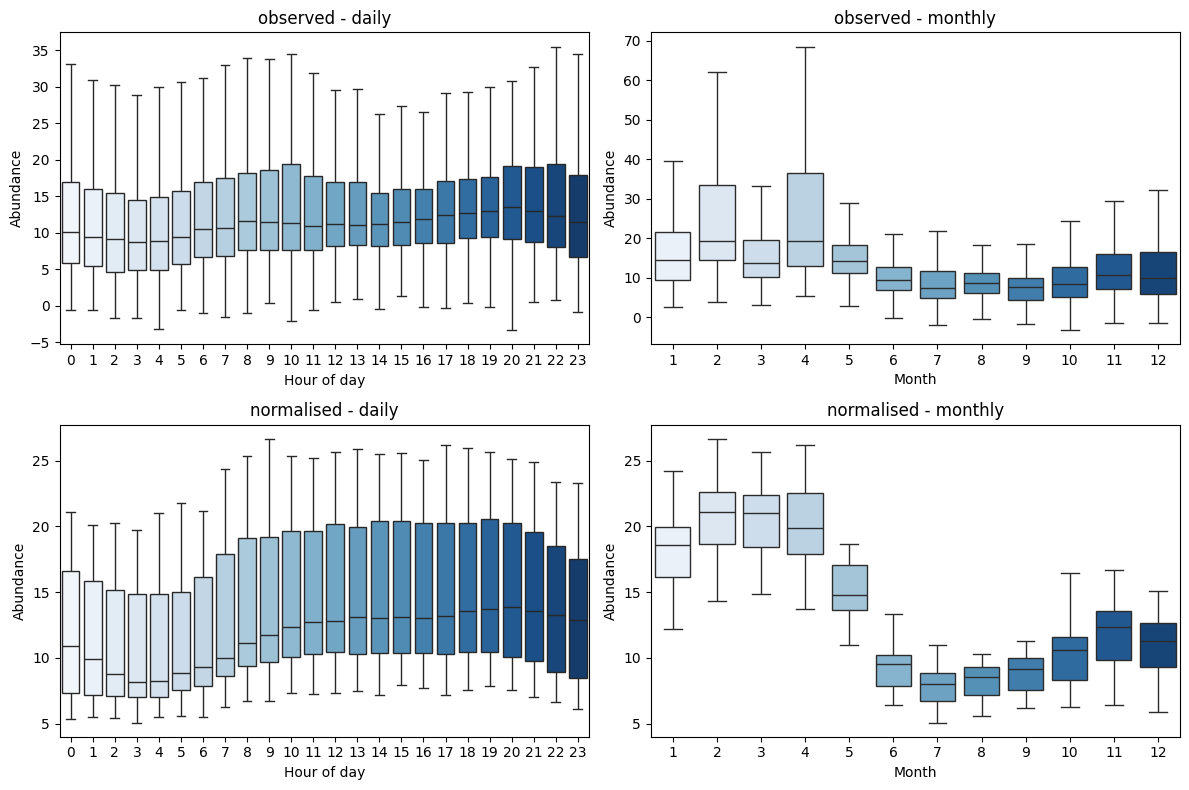

In [149]:
# each year
fig, axes = plt.subplots(2,2,figsize=(12,8))
combined_df_subset = df_dew_all[(df_dew6.index.year == 2019)]
sns.boxplot(data=combined_df_subset,x=combined_df_subset.index.hour, y=combined_df_subset['observed'], ax=axes[0,0], showfliers=False, palette="Blues").set(xlabel='Hour of day',ylabel='Abundance')
sns.boxplot(data=combined_df_subset,x=combined_df_subset.index.month, y=combined_df_subset['observed'], ax=axes[0,1],  showfliers=False, palette="Blues").set(xlabel='Month',ylabel='Abundance')
sns.boxplot(data=combined_df_subset,x=combined_df_subset.index.hour, y=combined_df_subset['normalised'], ax=axes[1,0],  showfliers=False, palette="Blues").set(xlabel='Hour of day',ylabel='Abundance')
sns.boxplot(data=combined_df_subset,x=combined_df_subset.index.month, y=combined_df_subset['normalised'], ax=axes[1,1],  showfliers=False, palette="Blues").set(xlabel='Month',ylabel='Abundance')
# --------------------------#
axes[0,0].set_title('observed - daily')
axes[0,1].set_title('observed - monthly')
axes[1,0].set_title('normalised - daily')
axes[1,1].set_title('normalised - monthly')
fig.tight_layout()

<font size="6">Step4: Exercise </font>

<font size="4">Exercise 1: Use Normet to normalize the NO<sub>2</sub> data from the MY1 station using one-step normalization process. You can utilize the new model configuration to save time, but you are also encouraged to design your own configuration to test for differences.</font>

In [150]:
new_model_config = {
    'time_budget': 100,                     # Total running time in seconds
    'metric': 'r2',                        # Primary metric for regression, 'mae', 'mse', 'r2', 'mape',...
    'estimator_list': ["lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"],            # List of ML learners: "lgbm", "rf", "xgboost", "extra_tree", "xgb_limitdepth"
    'task': 'regression',                  # Task type
    'eval_method': 'auto',                 # A string of resampling strategy, one of ['auto', 'cv', 'holdout'].
    'verbose': True                     # Print progress messages
}

In [151]:
start_time = time.time()
df_dew_no2, mod_stats_no2=nm.do_all(df,value='NO2',feature_names=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m','date_unix', 'day_julian', 'weekday',
       'hour'],variables_resample=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m'],model_config=new_model_config,n_samples=300)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

2024-08-18 04:41:48 : Training AutoML...
2024-08-18 04:43:38 : Best model is lgbm with best model parameters of {'n_estimators': 180, 'num_leaves': 484, 'min_child_samples': 36, 'learning_rate': 0.1594316824645424, 'log_max_bin': 8, 'colsample_bytree': 0.9882716197099741, 'reg_alpha': 0.004676080321450302, 'reg_lambda': 0.5377255028869998}
2024-08-18 04:43:39 : Normalising the dataset using the trained model in parallel.
2024-08-18 04:45:25 : Aggregating 300 predictions...
Execution time: 217.41 seconds


<Axes: xlabel='date'>

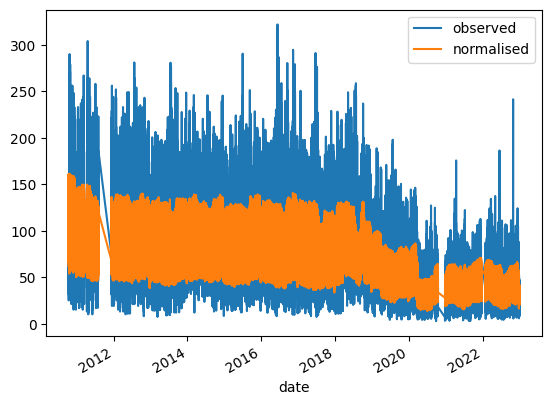

In [152]:
df_dew_no2.plot()

<font size="4">Exercise 2: Use Normet to normalize the NO<sub>2</sub> data from the MY1 station in 2019 using a one-step normalization process. You can utilize the new model configuration to save time, but you are also encouraged to design your own configuration to test for differences.</font>

In [153]:
df2019=df[(df.index.year == 2019)]

In [154]:
df2019

,O3,NO,NO2,SO2,CO,PM10,location_type,PM2.5,temp,v10,ssrd,blh,sp,rh2m,u10,tp
date,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,27.54066,27.59697,52.38422,1.89695,0.251524,26.3,Urban Traffic,20.4,5.5,0.300235,-1.875,379.22340,102624.440,85.955440,3.118221,9.760000e-07
2019-01-01 01:00:00,32.26382,23.98922,46.65609,2.01192,0.251524,20.7,Urban Traffic,20.1,4.6,0.461923,-1.875,291.84900,102602.440,86.403240,2.998127,4.880000e-07
2019-01-01 02:00:00,38.56690,21.54110,43.57085,1.94007,0.215171,12.5,Urban Traffic,9.7,4.4,0.361747,-1.875,263.67493,102614.125,86.999664,3.092967,0.000000e+00
2019-01-01 03:00:00,48.49551,10.40158,25.62631,1.33649,0.173905,10.8,Urban Traffic,8.9,4.1,0.106325,-1.875,263.39660,102601.234,87.812280,3.282647,0.000000e+00
2019-01-01 04:00:00,34.92475,16.79714,40.18036,1.55205,0.250542,11.1,Urban Traffic,9.9,4.0,-0.126249,-1.875,272.16187,102584.050,88.209900,3.479622,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,8.93076,42.60254,44.03810,3.02685,0.133817,27.9,Urban Traffic,22.6,5.0,0.480084,-1.875,503.32837,102358.060,100.335340,-4.073337,9.760000e-07
2019-12-31 20:00:00,11.17592,49.92257,44.75126,3.22864,0.165135,26.9,Urban Traffic,18.7,4.5,0.758353,-1.875,493.51965,102341.734,100.179000,-4.141801,2.200000e-06
2019-12-31 21:00:00,10.87657,39.91854,40.96164,3.02685,0.159441,30.1,Urban Traffic,20.2,2.9,1.423855,-1.875,486.07605,102328.330,99.785250,-3.943703,2.440000e-06


In [155]:
start_time = time.time()
df_dew_2019, mod_stats_2019,automl_2019=nm.do_all(df2019,value='NO2',feature_names=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m','date_unix', 'day_julian', 'weekday',
       'hour'],variables_resample=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m'],model_config=new_model_config,n_samples=300,return_model=True)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

2024-08-18 04:45:26 : Training AutoML...
2024-08-18 04:47:08 : Best model is xgboost with best model parameters of {'n_estimators': 84, 'max_leaves': 184, 'min_child_weight': 0.03469842703470486, 'learning_rate': 0.09050333780681966, 'subsample': 0.8788794424065157, 'colsample_bylevel': 0.7372635897769984, 'colsample_bytree': 0.9535003009271207, 'reg_alpha': 0.09353166342028453, 'reg_lambda': 3.6044671382295674}
2024-08-18 04:47:08 : Normalising the dataset using the trained model in parallel.
2024-08-18 04:47:10 : Aggregating 300 predictions...
Execution time: 104.57 seconds


In [156]:
df_dew_2019

,observed,normalised
date,,
2019-01-01 00:00:00,52.38422,52.240528
2019-01-01 01:00:00,46.65609,46.707287
2019-01-01 02:00:00,43.57085,45.209160
2019-01-01 03:00:00,25.62631,43.830990
2019-01-01 04:00:00,40.18036,46.833305
...,...,...
2019-12-31 19:00:00,44.03810,52.224258
2019-12-31 20:00:00,44.75126,51.716961
2019-12-31 21:00:00,40.96164,51.233635


In [157]:
start_time = time.time()
df_dew_2019a, mod_stats_2019a,automl_2019a=nm.do_all(df2019,value='NO2',feature_names=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m', 'day_julian', 'weekday',
       'hour'],variables_resample=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m'],model_config=new_model_config,n_samples=300,return_model=True)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

2024-08-18 04:47:10 : Training AutoML...
2024-08-18 04:48:53 : Best model is xgboost with best model parameters of {'n_estimators': 84, 'max_leaves': 184, 'min_child_weight': 0.03469842703470486, 'learning_rate': 0.09050333780681966, 'subsample': 0.8788794424065157, 'colsample_bylevel': 0.7372635897769984, 'colsample_bytree': 0.9535003009271207, 'reg_alpha': 0.09353166342028453, 'reg_lambda': 3.6044671382295674}
2024-08-18 04:48:53 : Normalising the dataset using the trained model in parallel.
2024-08-18 04:48:55 : Aggregating 300 predictions...
Execution time: 104.41 seconds


In [158]:
df_dew_2019a

,observed,normalised
date,,
2019-01-01 00:00:00,52.38422,51.979893
2019-01-01 01:00:00,46.65609,44.449005
2019-01-01 02:00:00,43.57085,42.472198
2019-01-01 03:00:00,25.62631,41.360600
2019-01-01 04:00:00,40.18036,45.830086
...,...,...
2019-12-31 19:00:00,44.03810,54.438515
2019-12-31 20:00:00,44.75126,52.783394
2019-12-31 21:00:00,40.96164,53.093208


In [159]:
importances = automl_2019.feature_importances_
feature_names = automl_2019.feature_names_in_

print(importances)
print(feature_names)

[0.08937755 0.02756967 0.01816038 0.2637257  0.0991143  0.0451112
 0.04067754 0.02337249 0.02892316 0.08119944 0.09453189 0.18823665]
['weekday' 'u10' 'tp' 'v10' 'ssrd' 'blh' 'temp' 'sp' 'rh2m' 'date_unix'
 'day_julian' 'hour']


In [160]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# df2019['date_unix'] = df2019.index.astype(np.int64) // 10**9
# df2019['day_julian'] = pd.DatetimeIndex(df2019.index).dayofyear
# # 假设你有一个DataFrame df，其中包括多个变量
# X = df2019[['date_unix', 'day_julian']]  # 你想计算VIF的变量集
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# print(vif_data)

In [162]:
from numpy.linalg import cond
df2019['date_unix'] = df2019.index.astype(np.int64) // 10**9
df2019['day_julian'] = pd.DatetimeIndex(df2019.index).dayofyear
X = df2019[['date_unix', 'day_julian']].values
condition_number = cond(X)
print(f"Condition Number: {condition_number}")


Condition Number: 14323747.18064545


/var/folders/8p/ny4s42v97yz7qg_ysw7z_rm00000gp/T/ipykernel_12731/873464787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2019['date_unix'] = df2019.index.astype(np.int64) // 10**9
/var/folders/8p/ny4s42v97yz7qg_ysw7z_rm00000gp/T/ipykernel_12731/873464787.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2019['day_julian'] = pd.DatetimeIndex(df2019.index).dayofyear


In [163]:
correlation = df2019['date_unix'].corr(df2019['day_julian'])
print(f"Pearson correlation coefficient: {correlation}")

Pearson correlation coefficient: 0.9999965365017898


<font size="4">Exercise 3: Use Normet to normalize the daily NO<sub>2</sub> data from the MY1 station using a one-step normalization process.</font>


In [164]:
df.pop('location_type')  # Remove the 'location_type' column from df
df_daily = df.resample('D').mean()



In [165]:
start_time = time.time()
df_dew_day, mod_stats_day,automl_day=nm.do_all(df_daily,value='NO2',feature_names=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m','date_unix', 'day_julian', 'weekday'],
                                               variables_resample=['u10', 'tp', 'v10', 'ssrd', 'blh', 'temp', 'sp','rh2m'],model_config=new_model_config,n_samples=300,return_model=True)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

2024-08-18 04:52:36 : Training AutoML...
2024-08-18 04:54:17 : Best model is lgbm with best model parameters of {'n_estimators': 597, 'num_leaves': 17, 'min_child_samples': 16, 'learning_rate': 0.09360027853198624, 'log_max_bin': 10, 'colsample_bytree': 0.8075404592869626, 'reg_alpha': 0.9932361033083701, 'reg_lambda': 0.0017268087317790079}
2024-08-18 04:54:17 : Normalising the dataset using the trained model in parallel.
2024-08-18 04:54:36 : Aggregating 300 predictions...
Execution time: 119.58 seconds


[ 212  979  751 1085  903  923  888  798  829 1323  861]
['weekday' 'u10' 'tp' 'v10' 'ssrd' 'blh' 'temp' 'sp' 'rh2m' 'date_unix'
 'day_julian']


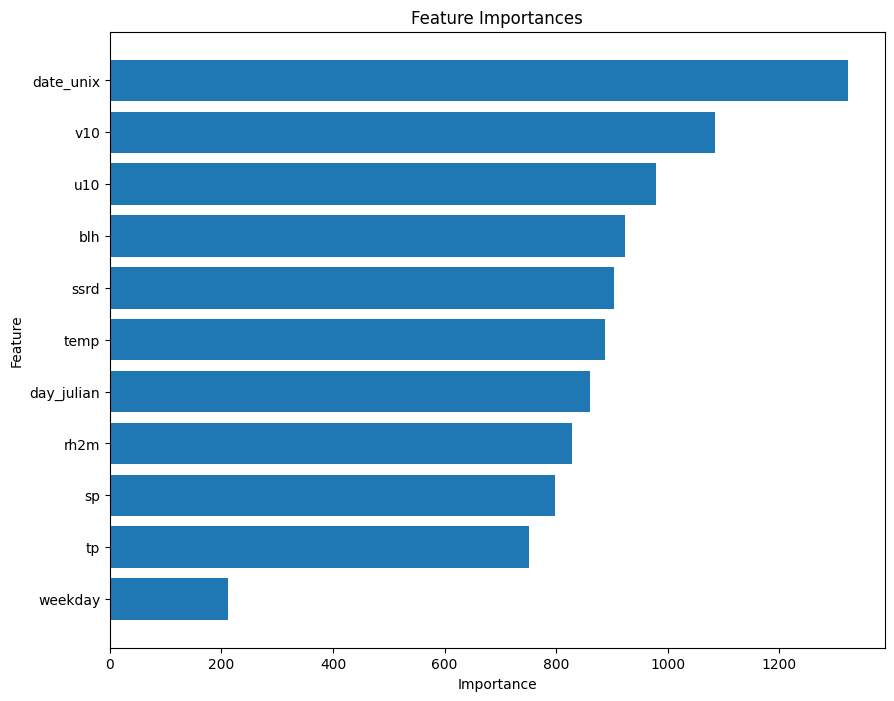

In [166]:
# daily 和hour的feature——importance一样么？- 自己运行，并对比
importances = automl_day.feature_importances_
feature_names = automl_day.feature_names_in_
indices = np.argsort(importances)
print(importances)
print(feature_names)
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

<Axes: xlabel='date'>

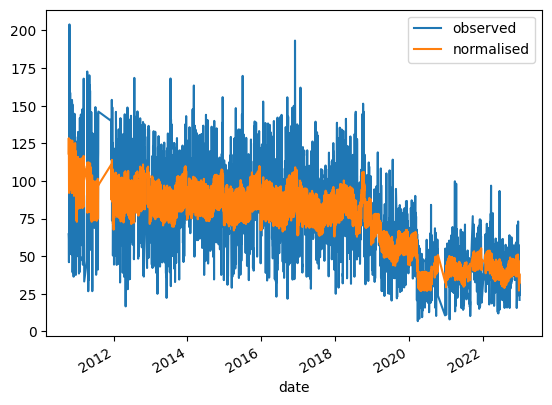

In [167]:
df_dew_day.plot()

In [168]:
mod_stats_day

,n,FAC2,MB,MGE,NMB,NMGE,RMSE,r,p_level,COE,IOA,R2,set
0,973,1.0,0.055324,7.357899,7.294070e-04,0.097009,9.737167,0.948762,***,0.711375,0.855687,0.900150,testing
1,2919,1.0,-0.000017,1.936610,-2.246070e-07,0.025347,2.616385,0.996698,***,0.927141,0.963571,0.993407,training
2,3892,1.0,0.013818,3.291932,1.811882e-04,0.043165,5.370029,0.985497,***,0.874875,0.937438,0.971205,all


<font size="4">Exercise 4: Experiment with other pollutants or scenarios in any way you like.</font>
